### Logistic Regression

I like to use Logistic Regression model as a baseline model because of its simplicity and interpretability. Unlike many other machine learning models, we can easily see how each explanatory variable is contributing to the prediction based on its coefficient estimates.

This is a relatively unbalanced dataset, so I used SMOTE oversampling on the training set, and it indeed improves the model performance (when testing the model on an original imbalanced test set). **In all other classification Machine Learning models with this dataset, I used the same SMOTE oversampling training and testing data** - to enable comparison. The data files are saved after preprocessing.

The process of running Logistic Regression model and examining the results also deepens my understanding of the dataset and informs variable selection based on our purpose of analysis.

As an exercise, self-implementation of logistic regression is also included in the last section.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#from sklearn.preprocessing import OneHotEncoder 

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
import os 
drive.mount('/gdrive/')

Mounted at /gdrive/


In [ ]:
df = pd.read_csv('/gdrive/MyDrive/INDE577/heart.csv')
df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


### Preprocessing

**Binary Variable**: No -> 0, Yes -> 1

**Multi-level Categorical Variable**: One Hot Encoding

In [ ]:
def cate_encoding(df, binary_vars, multi_vars):

  # change special values in some columns
  df['Diabetic'] =  df['Diabetic'].replace({'No, borderline diabetes':0,'Yes (during pregnancy)':1,'No':0,'Yes':1})
  df['Sex'] = df['Sex'].map({'Male':0,'Female':1})
  
  # encode binary variables
  for var in binary_vars:
    df[var] = df[var].map({'No':0,'Yes':1})

  # encode categorical variables having more than 2 levels

  # age is an ordinal variable, using one hot encoding results in too many variables
  age_values = sorted(df['AgeCategory'].unique())
  age_dict = {key: value for key, value in zip(age_values, list(range(13)))}  
  df['AgeCategory'] = df['AgeCategory'].map(age_dict)

  # encode race and genhealth
  encoded_categ = pd.get_dummies(df[['Race', 'GenHealth']])
  # drop base levels: white and poor
  encoded_categ.drop(['GenHealth_Poor','Race_White'], axis = 1, inplace = True)
  # concat back
  df = pd.concat([df, encoded_categ], axis = 1)

  # dropping the original categorical features
  df.drop(columns = ['Race', 'GenHealth'], axis = 1, inplace = True)

  return df

In [ ]:
binary_vars = ['HeartDisease','Smoking','AlcoholDrinking','Stroke','DiffWalking',
               'PhysicalActivity','Asthma','KidneyDisease','SkinCancer']
multi_vars = ['Race', 'GenHealth']
df = cate_encoding(df, binary_vars, multi_vars)
df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,...,SkinCancer,Race_American Indian/Alaskan Native,Race_Asian,Race_Black,Race_Hispanic,Race_Other,GenHealth_Excellent,GenHealth_Fair,GenHealth_Good,GenHealth_Very good
0,0,16.60,1,0,0,3.0,30.0,0,1,7,...,1,0,0,0,0,0,0,0,0,1
1,0,20.34,0,0,1,0.0,0.0,0,1,12,...,0,0,0,0,0,0,0,0,0,1
2,0,26.58,1,0,0,20.0,30.0,0,0,9,...,0,0,0,0,0,0,0,1,0,0
3,0,24.21,0,0,0,0.0,0.0,0,1,11,...,1,0,0,0,0,0,0,0,1,0
4,0,23.71,0,0,0,28.0,0.0,1,1,4,...,0,0,0,0,0,0,0,0,0,1


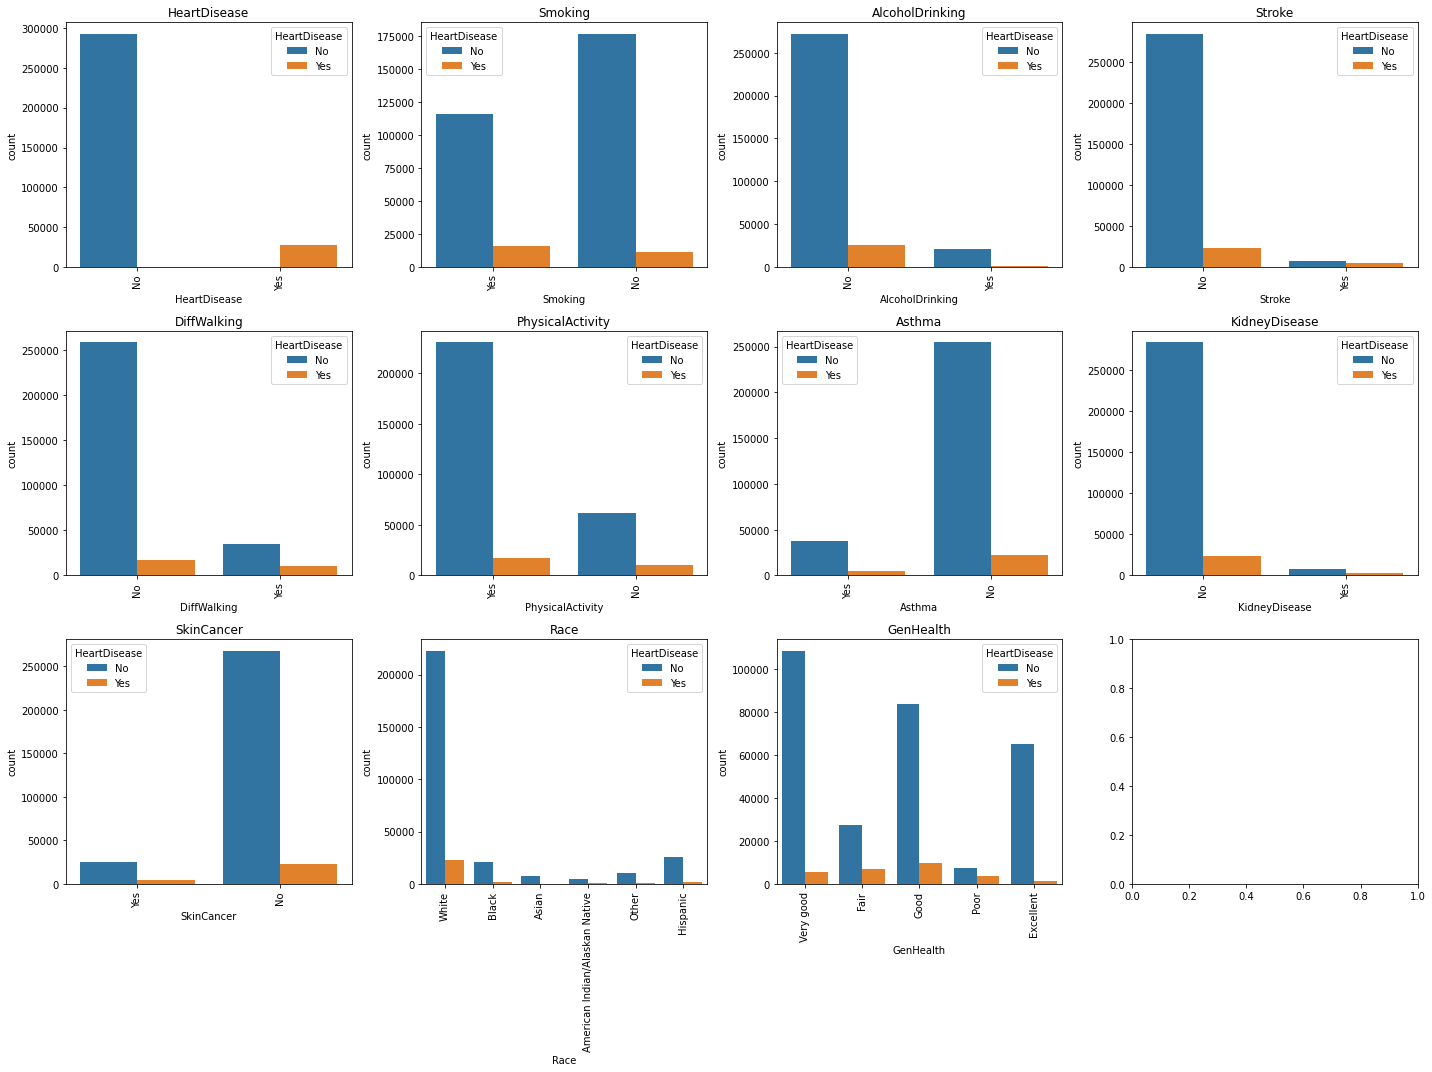

In [ ]:
df = pd.read_csv('/gdrive/MyDrive/INDE577/heart.csv')

var_lst = binary_vars + multi_vars
fig, axes = plt.subplots(3,4, figsize = (20,15))

for i in range(3):
  for j in range(4):

    if (4*i+j) == 11:
      break

    sns.countplot(x=var_lst[(4*i+j)], hue="HeartDisease", data=df, ax=axes[i,j])
    axes[i,j].set_title(var_lst[(4*i+j)])
    #axes[i,j].get_xaxis().set_visible(False)

    # rotate xlabels to avoid overlapping
    xlabels = axes[i,j].get_xticklabels()
    axes[i,j].set_xticklabels(xlabels, Rotation=90)

fig.tight_layout()
plt.show()

### Logistic Regression (with Python Package)


Note that in the exploratory analysis, we found that our target variable is HeartDisease, the positive samples are significantly fewer than the negative ones. We may try oversampling or undersampling techniques to deal with this imbalanced dataset.

Note that even if we use oversampling, we still want to test the model on an original, imbalanced test set! (as the model will be used for prediction in this way and it should have learnt to pick up features of rare positive cases)

In [ ]:
import statsmodels.api as sm
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report

#### If I use SMOTE

In [ ]:
# HeartDisease: No: 292422; Yes:27373
y = df['HeartDisease']
X = df.drop('HeartDisease', axis=1)

print('We have ', round(y.value_counts(normalize = True)[1] * 100, 4), '% positive samples in our data.')
os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns
os_data_X, os_data_y = os.fit_resample(X_train, y_train)
os_data_X = pd.DataFrame(data = os_data_X, columns = columns)

# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of HeartDisease in oversampled data", len(os_data_y[os_data_y==1]))
print("Proportion of no HeartDisease data in oversampled data is ",len(os_data_y[os_data_y==0])/len(os_data_X))
print("Proportion of HeartDisease data in oversampled data is ",len(os_data_y[os_data_y==1])/len(os_data_X))

We have  8.5595 % positive samples in our data.
length of oversampled data is  409384
Number of HeartDisease in oversampled data 204692
Proportion of no HeartDisease data in oversampled data is  0.5
Proportion of HeartDisease data in oversampled data is  0.5


In [ ]:
os_data_X = sm.add_constant(os_data_X)
logit_model=sm.Logit(os_data_y,os_data_X).fit()
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.397965
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:           HeartDisease   No. Observations:               409384
Model:                          Logit   Df Residuals:                   409359
Method:                           MLE   Df Model:                           24
Date:                Sat, 16 Apr 2022   Pseudo R-squ.:                  0.4259
Time:                        22:09:52   Log-Likelihood:            -1.6292e+05
converged:                       True   LL-Null:                   -2.8376e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                   1.9167      0.042 

It seems that smoking, alcodrinking, diffwalking, and several diseases like asthma and kidneyDieseas, skincancer might **have reversed signs** in our estimates. This maybe due to high correlation among variables. But this also reminds me to double check the definition of variables - some diseases (like kidneyDieseas, skincancer, stroke) may have a relative high rate of co-occrence with heart disease, and another variable DiffWalking (do you have difficulty walking or climing stairs) seems to be a result of heartdisease. 

Therefore, as our objective is to 'predict' if a person is highly likely to have heart disease (in future) based on lifestyles, we may not want to include these 'other disease' and 'result of heart disease' varaibles in our analysis as it may lead to leakage of information. It is better to remove these variables from analysis. See the next section - **'Remove some variables'** for analysis after removing these variables.

Accuracy of logistic regression classifier on test set: 0.79


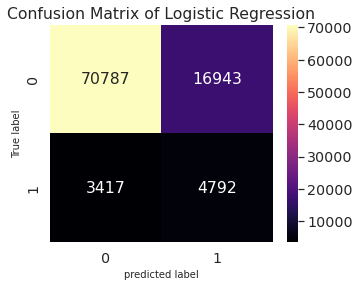

In [ ]:
X_test = sm.add_constant(X_test)
logreg = LogisticRegression()
logreg.fit(os_data_X,os_data_y)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

confusion_matrix = confusion_matrix(y_test, y_pred)
matrix_df = pd.DataFrame(confusion_matrix)

plt.figure(figsize=(5,4))
ax=plt.axes()
sns.set(font_scale=1.3)

sns.heatmap(matrix_df, annot=True, fmt='g', ax=ax, cmap='magma')
ax.set_title('Confusion Matrix of Logistic Regression')
ax.set_xlabel('predicted label', fontsize=10)
ax.set_ylabel('True label', fontsize=10)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.81      0.87     87730
           1       0.22      0.58      0.32      8209

    accuracy                           0.79     95939
   macro avg       0.59      0.70      0.60     95939
weighted avg       0.89      0.79      0.83     95939



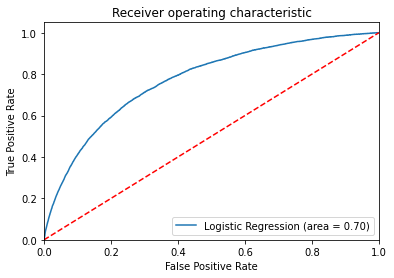

In [ ]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

#### Remove some variables

In [ ]:
def cate_encoding(df, binary_vars):

  # change special values in some columns
  df['Diabetic'] =  df['Diabetic'].replace({'No, borderline diabetes':0,'Yes (during pregnancy)':1,'No':0,'Yes':1})
  df['Sex'] = df['Sex'].map({'Male':0,'Female':1})
  
  # encode binary variables
  for var in binary_vars:
    df[var] = df[var].map({'No':0,'Yes':1})

  # encode categorical variables having more than 2 levels

  # age is an ordinal variable, using one hot encoding results in too many variables
  age_values = sorted(df['AgeCategory'].unique())
  age_dict = {key: value for key, value in zip(age_values, list(range(13)))}  
  df['AgeCategory'] = df['AgeCategory'].map(age_dict)

  # dropping the original categorical features
  df.drop(columns = ['Race', 'GenHealth'], axis = 1, inplace = True)

  return df

In [ ]:
df = pd.read_csv('/gdrive/MyDrive/INDE577/heart.csv')
df = df[['HeartDisease','BMI','Smoking','AlcoholDrinking','PhysicalHealth','MentalHealth','Sex','AgeCategory','Diabetic','PhysicalActivity','SleepTime','Race', 'GenHealth']]
binary_vars = ['HeartDisease','Smoking','AlcoholDrinking','PhysicalActivity']
df = cate_encoding(df, binary_vars)
df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,PhysicalHealth,MentalHealth,Sex,AgeCategory,Diabetic,PhysicalActivity,SleepTime
0,0,16.60,1,0,3.0,30.0,1,7,1,1,5.0
1,0,20.34,0,0,0.0,0.0,1,12,0,1,7.0
2,0,26.58,1,0,20.0,30.0,0,9,1,1,8.0
3,0,24.21,0,0,0.0,0.0,1,11,0,0,6.0
4,0,23.71,0,0,28.0,0.0,1,4,0,1,8.0


In [ ]:
# HeartDisease: No: 292422; Yes:27373
y = df['HeartDisease']
X = df.drop('HeartDisease', axis=1)

print('We have ', round(y.value_counts(normalize = True)[1] * 100, 4), '% positive samples in our data.')
os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns
os_data_X, os_data_y = os.fit_resample(X_train, y_train)
os_data_X = pd.DataFrame(data = os_data_X, columns = columns)

# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of HeartDisease in oversampled data", len(os_data_y[os_data_y==1]))
print("Proportion of no HeartDisease data in oversampled data is ",len(os_data_y[os_data_y==0])/len(os_data_X))
print("Proportion of HeartDisease data in oversampled data is ",len(os_data_y[os_data_y==1])/len(os_data_X))

We have  8.5595 % positive samples in our data.
length of oversampled data is  409384
Number of HeartDisease in oversampled data 204692
Proportion of no HeartDisease data in oversampled data is  0.5
Proportion of HeartDisease data in oversampled data is  0.5


In [ ]:
# save data files to be used by other models
os_data_X.to_csv('SMOTE_training_x.csv', index = False)
os_data_y.to_csv('SMOTE_training_y.csv', index = False)
X_test.to_csv('x_test.csv', index = False)
y_test.to_csv('y_test.csv', index = False)

In [ ]:
os_data_X = sm.add_constant(os_data_X)
logit_model=sm.Logit(os_data_y,os_data_X).fit()
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.513032
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:           HeartDisease   No. Observations:               409384
Model:                          Logit   Df Residuals:                   409373
Method:                           MLE   Df Model:                           10
Date:                Sat, 16 Apr 2022   Pseudo R-squ.:                  0.2599
Time:                        22:11:56   Log-Likelihood:            -2.1003e+05
converged:                       True   LL-Null:                   -2.8376e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -2.2265      0.031    -72.473      0.000      -2.287      -2.166
BMI        

Now the signs of coefficient estimates makes sense for me (note that definition of PhysicalHealth and MentalHealth is number of days in last 30 days that health **is not good**, and it should have a positive coefficient.).

The only thing that attract my attention is AlcoholDrinking - but I found information online that 'people who drank moderate amounts of alcohol (less than two drinks a day most days) had about a 20% lower risk of dying from heart disease'. However, this could also be because there are some unobserved confounders not included in our analysis and therefore lead to reversed sign of our estimate.

Accuracy of logistic regression classifier on test set: 0.72


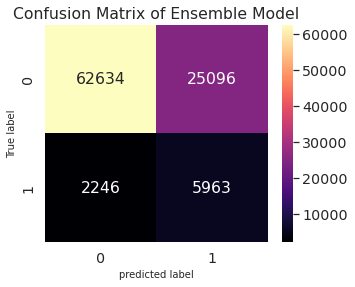

In [ ]:
X_test = sm.add_constant(X_test)
logreg = LogisticRegression()
logreg.fit(os_data_X,os_data_y)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

confusion_matrix = confusion_matrix(y_test, y_pred)
matrix_df = pd.DataFrame(confusion_matrix)

plt.figure(figsize=(5,4))
ax=plt.axes()
sns.set(font_scale=1.3)

sns.heatmap(matrix_df, annot=True, fmt='g', ax=ax, cmap='magma')
ax.set_title('Confusion Matrix of Ensemble Model')
ax.set_xlabel('predicted label', fontsize=10)
ax.set_ylabel('True label', fontsize=10)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.71      0.82     87730
           1       0.19      0.73      0.30      8209

    accuracy                           0.72     95939
   macro avg       0.58      0.72      0.56     95939
weighted avg       0.90      0.72      0.78     95939



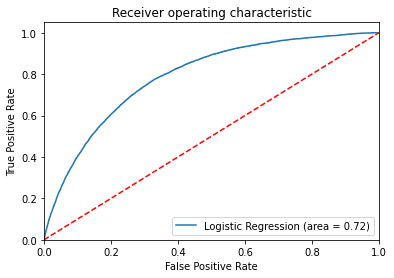

In [ ]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

We have a slightly higher ROC-AUC of 0.72 compared to 0.70 if not selecting variables. For positive cases, we have a higher recall but a lower precision (This is the tradeoff we usually have to make!). This might be desirable, as our goal is use this prediction to warn people who have a high risk of heart disease to adjust their lifestyles. Failing to warn someone who ends up with heart disease is a more severe kind of mistake than falsely warning someone who is not gonna have a heart disease.

#### If I do not use SMOTE (With selected variables)

We have a relative imbalanced dataset - with positive rate < 10%. We have been using SMOTE to oversample the positive cases, but what if we directly run the model on the original data?

In [ ]:
# HeartDisease: No: 292422; Yes:27373
y = df['HeartDisease']
X = df.drop('HeartDisease', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [ ]:
X_train = sm.add_constant(X_train)
logit_model=sm.Logit(y_train,X_train).fit()
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.240149
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:           HeartDisease   No. Observations:               223856
Model:                          Logit   Df Residuals:                   223845
Method:                           MLE   Df Model:                           10
Date:                Sat, 16 Apr 2022   Pseudo R-squ.:                  0.1783
Time:                        22:01:49   Log-Likelihood:                -53759.
converged:                       True   LL-Null:                       -65424.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -5.3850      0.067    -80.082      0.000      -5.517      -5.253
BMI        

 Let's check the model performance:

Accuracy of logistic regression classifier on test set: 0.91


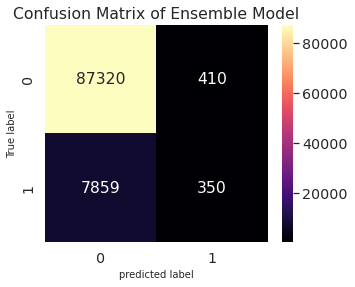

In [ ]:
X_test = sm.add_constant(X_test)
logreg = LogisticRegression()
logreg.fit(X_train,y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

confusion_matrix = confusion_matrix(list(y_test), list(y_pred))
matrix_df = pd.DataFrame(confusion_matrix)

plt.figure(figsize=(5,4))
ax=plt.axes()
sns.set(font_scale=1.3)

sns.heatmap(matrix_df, annot=True, fmt='g', ax=ax, cmap='magma')
ax.set_title('Confusion Matrix of Logistic Regression')
ax.set_xlabel('predicted label', fontsize=10)
ax.set_ylabel('True label', fontsize=10)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.95     87730
           1       0.46      0.04      0.08      8209

    accuracy                           0.91     95939
   macro avg       0.69      0.52      0.52     95939
weighted avg       0.88      0.91      0.88     95939



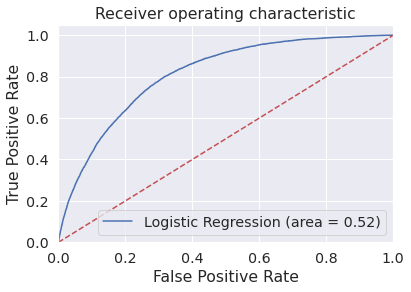

In [ ]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

The accuracy rate seems much higher than our oversampled model: but notice that the recall for class 1 is extremely low (0.04)! This indicates that the model is simply classifying most of the data it sees as the majority class, which is not desirable.

Therefore, based on the comparison, we prefer the model using oversampled training data.

### Logistic Regression (Implementation)

https://developer.ibm.com/articles/implementing-logistic-regression-from-scratch-in-python/


This section is just for exercise: using self-implementation of logistic regression instead of using Python packages

In [ ]:
import copy
from sklearn.metrics import accuracy_score

class LogisticRegression():
    def __init__(self):
        self.losses = []
        self.train_accuracies = []

    def fit(self, x, y, epochs):
        x = self._transform_x(x)
        y = self._transform_y(y)

        self.weights = np.zeros(x.shape[1])
        self.bias = 0

        for i in range(epochs):
            x_dot_weights = np.matmul(self.weights, x.transpose()) + self.bias
            pred = self._sigmoid(x_dot_weights)
            loss = self.compute_loss(y, pred)
            error_w, error_b = self.compute_gradients(x, y, pred)
            self.update_model_parameters(error_w, error_b)

            pred_to_class = [1 if p > 0.5 else 0 for p in pred]
            self.train_accuracies.append(accuracy_score(y, pred_to_class))
            self.losses.append(loss)

    def compute_loss(self, y_true, y_pred):
        # binary cross entropy
        y_zero_loss = y_true * np.log(y_pred + 1e-9)
        y_one_loss = (1-y_true) * np.log(1 - y_pred + 1e-9)
        return -np.mean(y_zero_loss + y_one_loss)

    def compute_gradients(self, x, y_true, y_pred):
        # derivative of binary cross entropy
        difference =  y_pred - y_true
        gradient_b = np.mean(difference)
        gradients_w = np.matmul(x.transpose(), difference)
        gradients_w = np.array([np.mean(grad) for grad in gradients_w])

        return gradients_w, gradient_b

    def update_model_parameters(self, error_w, error_b):
        self.weights = self.weights - 0.1 * error_w
        self.bias = self.bias - 0.1 * error_b

    def predict(self, x):
        x_dot_weights = np.matmul(x, self.weights.transpose()) + self.bias
        probabilities = self._sigmoid(x_dot_weights)
        return [1 if p > 0.5 else 0 for p in probabilities]

    def _sigmoid(self, x):
        return np.array([self._sigmoid_function(value) for value in x])

    def _sigmoid_function(self, x):
        if x >= 0:
            z = np.exp(-x)
            return 1 / (1 + z)
        else:
            z = np.exp(x)
            return z / (1 + z)

    def _transform_x(self, x):
        x = copy.deepcopy(x)
        return x.values

    def _transform_y(self, y):
        y = copy.deepcopy(y)
        return y.values.reshape(y.shape[0], 1)